In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from math import pi

In [21]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

class makedata(Dataset):
    def __init__(self, col, n_feat, maximum):
        self.col = col  # number of datapoints/columns
        self.n_feat = n_feat  # number of features/rows
        self.maximum = maximum   # factor to control the range of feature data
        self.classes = 2   # number of classes

        if col%2 != 0:
            col = col+1
            print("Making total number of datapoints an even number for ease: col =", col)
            
        self.Xdata1 = torch.rand(col//2, n_feat)*maximum +1.5
        self.Xdata2 = torch.rand(col//2, n_feat)*(-maximum) 
        self.Xdata = torch.cat((self.Xdata1, self.Xdata2), dim=0)

        self.Ydata = torch.cat((torch.full((col//2,), 1),torch.full((col//2,), -1)))       

    def __len__(self):
        return len(self.Ydata)

    def __getitem__(self, idx):
        return self.Xdata[idx],self.Ydata[idx]


In [22]:
r =5
col = 100
n_feat = 2
data = makedata(col, n_feat, r)

In [23]:
# print(len(data))
# print(data.Xdata1)
# print(data.Xdata2)
# print(data.Xdata1.shape)
# print(data.Ydata)

In [24]:
x,y = data.__getitem__(0)
print(x,y)

tensor([3.7518, 1.6069]) tensor(1.)


In [25]:
np_Xdata1 = data.Xdata1.detach().numpy()
np_Xdata2 = data.Xdata2.detach().numpy()

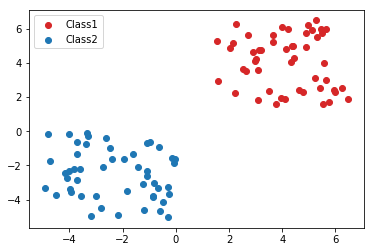

In [26]:
import matplotlib.pyplot as plt

colors = ("red", "blue")
groups = ("class 1", "class 2")

plt.scatter(np_Xdata1[:,0], np_Xdata1[:,1], color="tab:red", label= "Class1")
plt.scatter(np_Xdata2[:,0], np_Xdata2[:,1], color="tab:blue", label = "Class2")
plt.legend(loc = 'best')
plt.show()

In [27]:
batch_size = 20
data_batches = DataLoader(data, batch_size=batch_size, shuffle=True)
for d in data_batches:
    x,y = d
#     print("new",x,y)
# print(len(y.tolist()))

In [28]:
from pennylane.templates.embeddings import AmplitudeEmbedding

def randomlayer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0,1])

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface = 'torch')
def circuit(w, p=None):
    AmplitudeEmbedding(p, wires=[0,1], pad=True, normalize=True)
    randomlayer(w[0])
    randomlayer(w[1])
    randomlayer(w[2])
    randomlayer(w[3])
    return qml.expval(qml.PauliZ(0))

def classifier(w, b, p=None):
    return circuit(w, p=p) + b

In [29]:
def get_loss(w, b, x, y):
    loss = 0
    for d,l in zip(x,y):
        loss = loss + (classifier(w,b, p=d) - l)**2    
    return loss /len(y)

def get_loss_each(w, b, x, y):
    loss = 0
    loss = loss + (classifier(w,b, p=x) - y)**2    
    return loss 
    
# def check(w, x, y):
#     true_y = y.tolist()
#     pred_y = []
#     for d,l in zip(x,y):
#         res = circuit(w,p=d)
#         if res > 0:
#             pred_y.append(1)
#         else:
#             pred_y.append(-1)
#     diff = [a-b for a,b in zip(true_y, pred_y)]
#     return sum(abs(val) for val in diff)/len(true_y)


In [30]:
torch.manual_seed(1)
w = Variable(pi * torch.rand((4,2,3), dtype=torch.float64), requires_grad=True)
b =Variable(0.1 * torch.rand((1,), dtype=torch.float64) , requires_grad=True)
print(w)
print(b)

tensor([[[0.1918, 0.7055, 0.7359],
         [0.5564, 1.7469, 0.3438]],

        [[1.4480, 2.2254, 1.8214],
         [1.5603, 1.6034, 1.0353]],

        [[2.2563, 1.2080, 0.2821],
         [0.3690, 2.0114, 0.6182]],

        [[1.6099, 2.2363, 2.9056],
         [3.1406, 2.8046, 2.7543]]], dtype=torch.float64, requires_grad=True)
tensor([0.0845], dtype=torch.float64, requires_grad=True)


In [ ]:
#  for a,b in zip(x,y):
#     print(a)
#     res = circuit(w1_init, w2_init, p = a)
#     pred = [variational_classifier(var, x=x) for x in X]
#     print("pred", res)
#     print("actual", b)    

In [ ]:
# print(w1_init.grad)
# loss = get_loss(w1_init, w2_init, x, y)
# print(loss)
# loss.backward()
# print(w1_init.grad)

In [ ]:
# opt = torch.optim.RMSprop([w, b], lr = 0.5)
# rec= []
# for epoch in range(1000):    
#     for d in data_batches:
#         x,y = d
#         opt.zero_grad()
#         loss = get_loss(w, b, x, y)
#         loss.backward()
#         opt.step()
#     rec.append(loss.item())
#     print(loss)


In [31]:
opt = torch.optim.SGD([w, b], lr = 0.01)
rec= []
for steps in range(1000):    
    r_ind = np.random.randint(low=0, high=100)
    x,y = data.__getitem__(r_ind)
    opt.zero_grad()
    loss = get_loss_each(w, b, x, y)
    loss.backward()
    opt.step()
    rec.append(loss.item())
    if steps%10 ==0:
        print(steps, loss.item())
        print("gradient:", w.grad)


0 1.830814393160168
gradient: tensor([[[ 0.0000e+00, -9.3649e-01,  5.9241e-01],
         [-4.6981e-01, -4.7875e-01,  1.1006e+00]],

        [[ 5.9241e-01, -2.0141e-01,  3.1365e-01],
         [ 7.5562e-02, -1.1906e-01, -1.4914e+00]],

        [[ 3.1365e-01, -1.4948e+00,  9.4352e-01],
         [ 6.0894e-02,  3.6028e-03, -1.3736e-01]],

        [[ 9.4352e-01, -1.1976e+00,  0.0000e+00],
         [ 0.0000e+00,  1.5022e-16,  3.0044e-16]]], dtype=torch.float64)
10 1.7711170861105405
gradient: tensor([[[ 0.0000e+00, -1.9902e+00, -1.0665e-01],
         [-1.1025e+00,  1.6761e-01, -4.3283e-01]],

        [[-1.0665e-01, -9.3851e-01, -8.7513e-01],
         [-1.7466e-01, -1.2059e+00, -2.9725e-01]],

        [[-8.7513e-01, -7.4843e-01,  6.9057e-01],
         [ 9.4140e-01,  7.7919e-01, -1.0711e+00]],

        [[ 6.9057e-01, -5.1774e-01, -2.9550e-16],
         [ 1.4775e-16,  2.9550e-16, -1.4775e-16]]], dtype=torch.float64)
20 1.260107611070737
gradient: tensor([[[ 0.0000e+00, -1.7658e+00, -5.8914e-02],

180 0.7454154244772486
gradient: tensor([[[ 0.0000e+00,  1.2126e+00,  1.9118e-02],
         [ 5.9126e-01, -1.6809e-01,  2.7106e-01]],

        [[ 1.9118e-02,  6.2394e-01,  8.2739e-01],
         [ 1.8392e-01,  6.9220e-01,  2.6250e-01]],

        [[ 8.2739e-01,  4.8164e-01, -2.3684e-01],
         [-4.6158e-01, -4.4647e-01,  5.5556e-01]],

        [[-2.3684e-01,  4.7470e-01, -9.5854e-17],
         [-2.3963e-16, -9.5854e-17,  1.4378e-16]]], dtype=torch.float64)
190 0.8566216070010175
gradient: tensor([[[ 0.0000e+00, -3.2101e-01,  6.0780e-01],
         [-8.2491e-02, -6.8166e-01,  4.9185e-01]],

        [[ 6.0780e-01,  4.1370e-01,  3.6213e-01],
         [-8.7049e-02,  1.0218e-01, -1.2791e+00]],

        [[ 3.6213e-01, -1.1051e+00,  3.0871e-01],
         [ 3.2694e-02,  1.3840e-01,  1.2420e-01]],

        [[ 3.0871e-01, -1.2895e+00, -1.7982e-16],
         [ 6.4222e-17,  6.4222e-17, -2.5689e-17]]], dtype=torch.float64)
200 1.594965498661681
gradient: tensor([[[ 0.0000e+00, -1.5842e+00, -3.0132e

360 1.1445597745422977
gradient: tensor([[[ 0.0000e+00,  1.3216e+00,  9.2811e-02],
         [ 6.7108e-01, -3.4479e-01,  7.6980e-02]],

        [[ 9.2811e-02,  8.7879e-01,  1.0433e+00],
         [ 1.0847e-01,  8.2786e-01,  3.2048e-01]],

        [[ 1.0433e+00,  5.8807e-01, -2.5113e-01],
         [-4.0654e-01, -4.3806e-01,  6.4073e-01]],

        [[-2.5113e-01,  4.9715e-01,  1.1878e-16],
         [ 1.1878e-16, -1.1878e-16, -3.5633e-16]]], dtype=torch.float64)
370 1.105614789454472
gradient: tensor([[[ 0.0000e+00, -1.2266e+00, -4.9187e-02],
         [-5.7014e-01,  4.3863e-01, -1.4731e-01]],

        [[-4.9187e-02, -8.8807e-01, -1.0629e+00],
         [-4.8484e-02, -7.3407e-01, -1.4552e-01]],

        [[-1.0629e+00, -5.3590e-01,  9.1552e-02],
         [ 4.2180e-01,  4.9836e-01, -5.7847e-01]],

        [[ 9.1552e-02, -3.3038e-01, -2.9184e-16],
         [-2.9184e-16,  1.1674e-16, -2.3348e-16]]], dtype=torch.float64)
380 1.617223785397537
gradient: tensor([[[ 0.0000e+00,  7.6033e-01, -4.8642e-

540 1.2887643272770783
gradient: tensor([[[ 0.0000e+00, -2.6305e-01,  3.3691e-01],
         [-2.7066e-01, -1.1549e+00, -4.7678e-02]],

        [[ 3.3691e-01, -1.1319e-01, -4.5792e-01],
         [-7.2648e-01, -2.5645e-01, -1.5752e+00]],

        [[-4.5792e-01, -6.8850e-01, -5.5708e-04],
         [ 9.4235e-03,  2.9523e-02,  3.0093e-02]],

        [[-5.5708e-04, -1.5229e+00, -1.2604e-16],
         [ 0.0000e+00,  1.8906e-16,  1.8906e-16]]], dtype=torch.float64)
550 1.600583022419273
gradient: tensor([[[ 0.0000e+00, -9.5173e-01,  3.9991e-02],
         [-4.0661e-01,  5.4696e-01,  1.0669e-03]],

        [[ 3.9991e-02, -1.1080e+00, -1.1325e+00],
         [-2.1681e-02, -5.7719e-01,  3.8651e-02]],

        [[-1.1325e+00, -5.3609e-01, -1.4195e-01],
         [ 3.0872e-01,  4.4934e-01, -4.1312e-01]],

        [[-1.4195e-01,  1.9569e-02,  1.4046e-16],
         [ 2.8092e-16,  0.0000e+00,  2.8092e-16]]], dtype=torch.float64)
560 0.8617371268835556
gradient: tensor([[[ 0.0000e+00,  6.3122e-01, -1.2109e

720 0.736813007826547
gradient: tensor([[[ 0.0000e+00,  3.3598e-01, -1.4502e-01],
         [ 2.1498e-01,  5.0083e-01,  5.6471e-02]],

        [[-1.4502e-01,  4.5120e-01,  5.8114e-01],
         [ 4.1608e-01,  2.5527e-01,  7.9584e-01]],

        [[ 5.8114e-01,  3.9457e-01,  7.7476e-02],
         [-3.3751e-02, -4.8036e-02,  6.4933e-02]],

        [[ 7.7476e-02,  7.6609e-01,  9.5299e-17],
         [-9.5299e-17, -1.9060e-16,  0.0000e+00]]], dtype=torch.float64)
730 1.0214905197991748
gradient: tensor([[[ 0.0000e+00,  1.8626e-01, -2.2870e-01],
         [ 1.9148e-01,  1.0260e+00,  9.1006e-02]],

        [[-2.2870e-01,  2.1399e-01,  4.4517e-01],
         [ 6.4082e-01,  2.2530e-01,  1.3614e+00]],

        [[ 4.4517e-01,  5.3316e-01,  5.0275e-02],
         [ 6.1051e-03,  4.7176e-03, -2.8145e-02]],

        [[ 5.0275e-02,  1.3320e+00,  0.0000e+00],
         [-4.4884e-16,  0.0000e+00, -1.1221e-16]]], dtype=torch.float64)
740 0.24407676610914586
gradient: tensor([[[ 0.0000e+00, -3.2831e-01,  2.8402

900 1.6250209647449252
gradient: tensor([[[ 0.0000e+00, -5.9344e-01,  8.1689e-02],
         [-1.8274e-01,  4.4313e-01,  6.3230e-02]],

        [[ 8.1689e-02, -1.0201e+00, -8.3333e-01],
         [-1.7894e-02, -2.9227e-01,  1.1944e-01]],

        [[-8.3333e-01, -5.2074e-01, -2.5979e-01],
         [ 1.6692e-01,  2.9283e-01, -1.7119e-01]],

        [[-2.5979e-01,  1.8474e-01, -1.4153e-16],
         [ 1.4153e-16,  1.4153e-16, -1.4153e-16]]], dtype=torch.float64)
910 0.748426546579067
gradient: tensor([[[ 0.0000e+00,  2.9192e-01, -1.2256e-01],
         [ 1.3663e-01,  4.3130e-01,  7.6694e-02]],

        [[-1.2256e-01,  4.9369e-01,  5.5299e-01],
         [ 3.5815e-01,  1.8016e-01,  6.7264e-01]],

        [[ 5.5299e-01,  3.7614e-01,  1.4880e-01],
         [-1.9604e-02, -3.3063e-02,  2.6591e-02]],

        [[ 1.4880e-01,  6.3300e-01,  2.8814e-16],
         [ 1.9209e-16, -1.9209e-16,  9.6047e-17]]], dtype=torch.float64)
920 1.0881521371273826
gradient: tensor([[[ 0.0000e+00,  6.9618e-01, -6.8508e

In [32]:
fin1, fin2 = opt.param_groups[0]['params']
print(fin1.grad)

tensor([[[ 0.0000e+00,  1.6932e-01, -6.9946e-02],
         [ 8.1461e-02,  3.9305e-01,  6.3152e-02]],

        [[-6.9946e-02,  4.0458e-01,  3.4453e-01],
         [ 2.8338e-01,  1.2527e-01,  5.4112e-01]],

        [[ 3.4453e-01,  3.2318e-01,  1.2336e-01],
         [ 1.0988e-02,  2.2080e-02,  3.0700e-03]],

        [[ 1.2336e-01,  4.9111e-01,  1.7116e-16],
         [ 0.0000e+00, -3.4232e-16,  0.0000e+00]]], dtype=torch.float64)


In [33]:
with torch.no_grad():
    x,y = data.__getitem__(2)    
    pred = classifier(fin1,fin2,x)
    print(pred, y)

tensor([0.2691], dtype=torch.float64) tensor(1.)


<function matplotlib.pyplot.show(*args, **kw)>

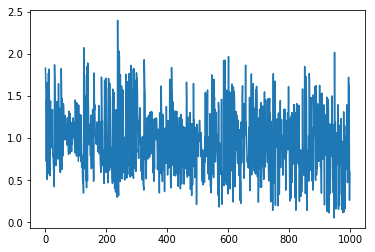

In [34]:

plt.plot(rec)
plt.show